This notebook is written by dr.Seyran Khademi for CIPA2019 Workshop on Computer Vision for Cultural Heritage.

What is so typical urban scene of a city that discreminates it from other cities? 
Often we remember a city that we visited as a tourist by its landmarks e.g., Tokyo by its tower or the ancient Buddhist temple. However, a local would most probably descibe Tokyo by other features such as its narrow pedestrain sidewalks. How about asking what is the most distingushing feature of Tokyo once compared to an American city e.g., Pittsburgh? The most reliable person to answer the former question is someone who have seen (or perhaps lived) in both places so he/she can provide us with a fair comparison on urban apperance in Tokyo v.s. Pittsburgh. Perhaps it is not easy to find your expert in this case. What about an AI assistant who has explored both cities and now is ready to show you its obseravtion? 

In this Workshop we ask computer to show us its view on the most distingusging urbun elements after extensive sightseeing in Tokyo and Pittsburgh. 



In [77]:
# Import required libraries 
import torch
from torchvision import models
import os
import torch.nn as nn
device = torch.device('cpu')
import cv2 
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
from torch.autograd import Variable

In [78]:
class Simple(nn.Module):
	    def __init__(self):
	        super(Simple,self).__init__()
	        self.features = nn.Sequential(
	            nn.Conv2d(3,20,5),
	            nn.ReLU(True),
	            nn.MaxPool2d(2,2),
	            nn.Conv2d(20,64,7),
	            nn.ReLU(True),
	            nn.MaxPool2d(2,2),
	            nn.Conv2d(64,96,5),
	            nn.ReLU(True),
	            nn.MaxPool2d(2,2),
	            nn.Conv2d(96,128,7),
	            nn.ReLU(True),
	            nn.MaxPool2d(2,2),
	        )
	        self.classifier = nn.Sequential(
	            nn.Linear(128*9*9,4096),
	            nn.ReLU(True),
	            nn.Dropout(),
	            nn.Linear(4096,100),
	            nn.ReLU(True),
	            nn.Dropout(),
	            nn.Linear(100,2),
	        )
	    def forward(self,x):
	        x = self.features(x)
	        x = x.view(x.size(0),-1)
	        x = self.classifier(x)
	        return x


In [79]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    #Image(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [80]:
def preprocess_image(img):
	mean=[0.485, 0.456, 0.406]
	std=[0.229, 0.224, 0.225]
	# opencv imread in BGR order, this code adjust the order of image channel into RGB
	preprocessed_img = img.copy()[: , :, ::-1]
	# image normalization
	for i in range(3):
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - mean[i]
		preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / std[i]
	# coverting a numpy Height*Width*nChannels array to nChannels*Height*Width
	preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
	preprocessed_img = torch.from_numpy(preprocessed_img)
	# adding one fake dimension (nTensorSamples*nChannels*Height*Width)
	preprocessed_img.unsqueeze_(0)
	image = Variable(preprocessed_img, requires_grad = True)
	return image 

In [81]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


In [82]:
class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model.features, target_layers)

	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		output = self.model.classifier(output)
		return target_activations, output

In [83]:
class GradCam:
	def __init__(self, model, target_layer_names, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()
		self.extractor = ModelOutputs(self.model, target_layer_names)

	def forward(self, input):
		return self.model(input) 

	def __call__(self, input, index = None):
		if self.cuda:
			features, output = self.extractor(input.cuda())
		else:
			features, output = self.extractor(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = Variable(torch.from_numpy(one_hot), requires_grad = True)
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		self.model.features.zero_grad()
		self.model.classifier.zero_grad()
		one_hot.backward(retain_graph=True)

		grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

		target = features[-1]
		target = target.cpu().data.numpy()[0, :]

		weights = np.mean(grads_val, axis = (2, 3))[0, :]
		cam = np.ones(target.shape[1 : ], dtype = np.float32)

		for i, w in enumerate(weights):
			cam += w * target[i, :, :]

		cam = np.maximum(cam, 0)
		cam = cv2.resize(cam, (224, 224))
		cam = cam - np.min(cam)
		cam = cam / np.max(cam)
		return cam

In [84]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

In [85]:
def generate_heatmap(mask):
	heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
	heatmap = np.float32(heatmap) / 255
	return heatmap

In [86]:
cd '/Users/seyran/GitHub/CIPA2019_Workshop/Xiangwei_Thesis'

/Users/seyran/GitHub/CIPA2019_Workshop/Xiangwei_Thesis


In [87]:
# Load the classifier
model = Simple()
model.load_state_dict(torch.load('Simple.pth', map_location=device))
model.eval()
use_gpu = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_cam = GradCam(model = model, target_layer_names = ['10'], use_cuda = use_gpu)

In [93]:
img = cv2.imread('/Users/seyran/GitHub/CIPA2019_Workshop/Xiangwei_Thesis/pitts_test3.jpeg',1)
img = np.float32(cv2.resize(img,(224,224)))/25
processed_img = preprocess_image(img)
prediction=model(processed_img)
print(prediction)
values, target_index = torch.max(prediction,1) # take the maximum, 0 for Pittsburgh, 1 for Tokyo
print(target_index)

tensor([[ 154.3401, -153.8553]], grad_fn=<AddmmBackward>)
tensor([0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


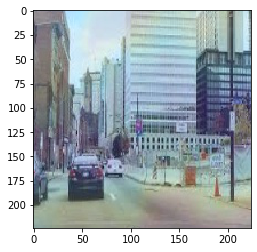

In [94]:
mask = grad_cam(processed_img,None)
heatmap = generate_heatmap(mask)
#save heatmap only
#cv2.imwrite(heatmap_save_root, np.uint8(heatmap*255))
#save heatmap with original image
cam = heatmap + img
cam = cam / np.max(cam) 
cv2.imwrite('/Users/seyran/GitHub/CIPA2019_Workshop/Xiangwei_Thesis/heatmap_test.jpeg', np.uint8(cam*255))
show_image(process_image('/Users/seyran/GitHub/CIPA2019_Workshop/Xiangwei_Thesis/heatmap_test.jpeg'))